# Sensitivity Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import collections
import seaborn as sns
import os
from pathlib import Path
import glob
import re
from cycler import cycler
import itertools

import fiona
import geopandas as gp
from shapely.geometry import LineString, Point, Polygon

%matplotlib inline

sns.color_palette()

sns.set_style("white", {"xtick.direction": "in","ytick.direction": "in"})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6]) 
my_tiel = (0.4, 0.7607843137254902, 0.6470588235294118) # Recycling
my_orange = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961) # Manufacturing
my_purple = (0.5529411764705883, 0.6274509803921569, 0.796078431372549) # 40209
my_pink = (0.9058823529411765, 0.5411764705882353, 0.7647058823529411) #NAICS

### Setup all file scenarios

The files I am going to load are the ones showed in the table below. This is to know which file correspond to what. I have not added the dates in the file name since they are autogenerated and it is a sanity check for me, but in reality the dates (numbers in front of the file name scenario) don't matter.
![scenarios_info.png](resources/scenarios_info_cost.png)
![scenarios_info_cap.png](resources/scenarios_info_capacity.png)

In [2]:
cwd = os.getcwd()

In [3]:
facility_label = ['Manufacturing', 'Recycling','Manufacturing_cap', 'Recycling_cap']
location_label = ['NAICS', '40209']
factor_label_rec = ['05', '1', '2', '5', '10']
factor_label_man = ['05', '1', '2', '5', '10'] # 0 is 0,5

In [4]:
files_list = []
for fac in facility_label:
    for loc in location_label:
        if fac.startswith('Manufacturing'):
            for fac_man in factor_label_man:
                files_list.append(fac+'_'+loc+'_'+fac_man)
        else:
            for fac_rec in factor_label_rec:
                files_list.append(fac+'_'+loc+'_'+fac_rec) 

In [5]:
facility_label_both = ['Manufacturing', 'Recycling']
location_label = ['BOTH', 'BOTHS']
discount_yn = ['ND', 'D']
discount_perc = ['10']
factor_label = ['1']
 # add the appropiate discount or a list of discounts, the numbers are in %

In [6]:
for faci in facility_label_both:
    for loc in location_label:
        for disc in discount_yn:
            if disc.startswith('ND'):
                for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+fac)
            else:
                for perc in discount_perc:
                    for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+perc+'_'+fac) 

#### Group the files into smaller bins for easier handling

In [40]:
recycling_files = [x for x in files_list if x.startswith('Recycling')]
recycling_files_cap = [x for x in recycling_files if "cap" in x]
recycling_files_cost = [x for x in recycling_files if "cap" not in x]
recycling_files_both_d = [x for x in recycling_files if "BOTH" in x and 'ND' not in x]
recycling_files_both_nd = [x for x in recycling_files if "BOTH" in x and 'ND' in x]


In [39]:
recycling_files_both_d

['Recycling_BOTH_D_10_1', 'Recycling_BOTHS_D_10_1']

In [41]:
manufacturing_files = [x for x in files_list if x.startswith('Manufacturing')]
manufacturing_files_cap = [x for x in manufacturing_files if "cap" in x]
manufacturing_files_cost = [x for x in manufacturing_files if "cap" not in x]
manufacturing_files_both_d = [x for x in manufacturing_files if "BOTH" in x and 'ND' not in x]
manufacturing_files_both_nd = [x for x in manufacturing_files if "BOTH" in x and 'ND' in x]

#### Dictionary to change year number to actual years

In [28]:
year_list = list(range(2025, 2051, 1))
number_year = list(range(1, 27, 1))
years_dict = dict(zip(number_year,year_list))


#### Load plant files

In [29]:
previous_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir) # Get previous folder from current directory

In [30]:
previous_folder

'/Users/hwikoff/Documents/RICE/3_RELOG_simulation'

##### Recycling cost

In [ ]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'outpput', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Some of the manufacturing files have no solution, so we remove them:

##### Manufacturing cost

In [ ]:
manufacturing_files_cost

In [ ]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

##### Recycling capacity

In [ ]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Manufacturing capacity

In [ ]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Recycling both NO DISCOUNT

In [42]:
for files in recycling_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_BOTH_ND_1: 81 locations
Recycling_BOTHS_ND_1: 81 locations


##### Recycling both DISCOUNT

In [42]:
for files in recycling_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_BOTH_ND_1: 81 locations
Recycling_BOTHS_ND_1: 81 locations


##### Manufacturing both NO DISCOUNT

In [ ]:
for files in manufacturing_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Manufacturing both DISCOUNT

In [ ]:
for files in manufacturing_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

### Selected locations plot

In [45]:
rec_cap_locs_data = [['Capacity', 'Recycling', 'NAICS', 0.5, 161], 
                     ['Capacity', 'Recycling','NAICS',1, 81], 
                     ['Capacity', 'Recycling','NAICS',2, 41],
                     ['Capacity', 'Recycling','NAICS',5, 17],
                     ['Capacity', 'Recycling','NAICS',10, 9],
                     ['Capacity', 'Recycling', '40209', 0.5, 161], 
                     ['Capacity', 'Recycling','40209',1, 81], 
                     ['Capacity', 'Recycling','40209',2, 41],
                     ['Capacity', 'Recycling','40209',5, 17],
                     ['Capacity', 'Recycling','40209',10, 10],
                     ['Cost', 'Recycling', 'NAICS',0.5, 81], 
                     ['Cost', 'Recycling','NAICS',1, 81], 
                     ['Cost', 'Recycling','NAICS',2, 81],
                     ['Cost', 'Recycling','NAICS',5, 81],
                     ['Cost', 'Recycling','NAICS',10, 81],
                     ['Cost', 'Recycling', '40209',0.5, 81], 
                     ['Cost', 'Recycling','40209',1, 81], 
                     ['Cost', 'Recycling','40209',2, 81],
                     ['Cost', 'Recycling','40209',5, 81],
                     ['Cost', 'Recycling','40209',10, 81],
                     ['Both', 'Recycling', 'All', 1, 81],
                     ['Both', 'Recycling', 'Selected', 1, 81],
                     ['Capacity', 'Manufacturing', 'NAICS',0.5, 124],
                     ['Capacity', 'Manufacturing', 'NAICS',1, 62],
                     ['Capacity', 'Manufacturing', 'NAICS',2, 31],
                     ['Capacity', 'Manufacturing', '40209', 0.5, 124],
                     ['Capacity', 'Manufacturing', '40209', 1, 62],
                     ['Capacity', 'Manufacturing', '40209', 2, 31],
                     ['Cost', 'Manufacturing', 'NAICS',0.001, 151],
                     ['Cost', 'Manufacturing', 'NAICS',0.5, 62],
                     ['Cost', 'Manufacturing', 'NAICS',1, 62],
                     ['Cost', 'Manufacturing', 'NAICS',2, 62],
                     ['Cost', 'Manufacturing', '40209',0.001, 143],
                     ['Cost', 'Manufacturing', '40209',0.5, 62],
                     ['Cost', 'Manufacturing', '40209',1, 62],
                     ['Cost', 'Manufacturing', '40209',2, 62],
                     ['Both', 'Manufacturing', 'All', 1, 62], # Changeee
                     ['Both', 'Manufacturing', 'Selected', 1, 62]] 

rec_cap_locs_data_df = pd.DataFrame(rec_cap_locs_data, columns=['Analysis', 'Facility', 'Location group','Factor', 'Selected locations'])

#### Recycling

In [46]:
factors_rec = [0.5, 1, 2, 5, 10]

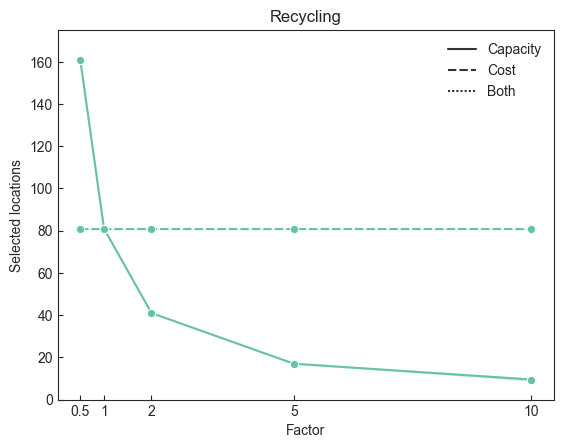

In [47]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Recycling'], marker='o', style="Analysis", color=my_tiel)
figure.legend(frameon=False)
figure.set(title='Recycling', ylim = (0, 175))
plt.xticks(factors_rec, labels = factors_rec)
plt.savefig(os.path.join(cwd, f"recycling_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"recycling_selected.pdf"), dpi=300);

#### Manufacturing

In [48]:
factors_man = [0.001, 0.5, 1, 2]

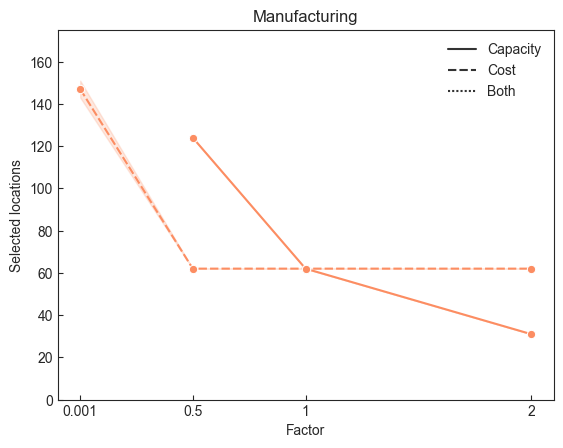

In [49]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Manufacturing'], marker='o', style="Analysis", color=my_orange)
figure.legend(frameon=False)
figure.set(title='Manufacturing', ylim = (0, 175))
plt.xticks(factors_man, labels = factors_man)
plt.savefig(os.path.join(cwd, f"manufacturing_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"manufacturing_selected.pdf"), dpi=300);

### Grid plot

#### Recycling Capacity Utilization Factor

In [ ]:
for files in recycling_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color=my_tiel)
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= my_tiel, alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    #grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}", y=1.2)


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_uf.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_uf.pdf"), dpi=300);


#### Recycling Capacity Total Cost

In [ ]:
for files in recycling_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color=my_tiel)
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= my_tiel, alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_totcost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_totcost.pdf"), dpi=300);

#### Recycling Cost Utilization Factor

In [ ]:
for files in recycling_files_cost:
# Initialize a grid of plots with an Axes for each walk
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color=my_tiel)
    grid.map(plt.fill_between, "year", 'utilization factor (%)',color= my_tiel, alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_uf.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_uf.pdf"), dpi=300);

#### Recycling Cost Total Cost

In [ ]:
for files in recycling_files_cost:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color=my_tiel)
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= my_tiel, alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_totcost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_totcost.pdf"), dpi=300);


#### Manufacturing Capacity Utilization Factor

In [ ]:
for files in manufacturing_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color=my_orange)
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= my_orange, alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_uf.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_uf.pdf"), dpi=300);


#### Manufacturing Capacity Total Cost

In [ ]:
for files in manufacturing_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color=my_orange)
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= my_orange, alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_totcost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cap_totcost.pdf"), dpi=300);


#### Manufacturing Cost Utilization Factor

In [ ]:
for files in manufacturing_files_cost:
# Initialize a grid of plots with an Axes for each walk
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color=my_orange)
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= my_orange, alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_uf.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_uf.pdf"), dpi=300);


#### Manufacturing Cost Total Cost

In [ ]:
for files in manufacturing_files_cost:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color=my_orange)
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= my_orange, alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_totcost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, f"grid_26_years/grid_{files}_cost_totcost.pdf"));


### Map plots

USA map [source2](https://esri.maps.arcgis.com/home/item.html?id=8c2d6d7df8fa4142b0a1211c8dd66903).

In [62]:
import fiona
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import collections
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, Polygon

%matplotlib inline

#### Load transportation files

##### Recycling cost

In [ ]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling capacity

In [ ]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling both NO DISCOUNT

In [53]:
recycling_files_both_nd

['Recycling_BOTH_ND_1', 'Recycling_BOTHS_ND_1']

In [56]:
for files in recycling_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, "simulations", files,'output', 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling both DISCOUNT

##### Manufacturing cost

In [ ]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing capacity

In [ ]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

#### Recycling cost maps

In [ ]:
my_tiel = (0.4, 0.7607843137254902, 0.6470588235294118)

In [ ]:
for files in recycling_files_cost:    
    # Plot base map
    world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=1,
            color=my_tiel,
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_tiel, markersize=10, edgecolor='white', linewidth=0.5)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_tiel , edgecolor='white', linewidth=0.5)

    legend_elements = [Line2D([0], [0], color=my_tiel, lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_tiel, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_tiel, label='Recycling center', markersize=10, linestyle='None')]
    ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))   

    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cost.pdf"), dpi=300);

#### Recycling capacity maps

In [ ]:
for files in recycling_files_cap:    
    # Plot base map
    world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=1,
            color=my_tiel,
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_tiel, markersize=10, edgecolor='white', linewidth=0.5)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_tiel, edgecolor='white', linewidth=0.5)

    legend_elements = [Line2D([0], [0], color=my_tiel, lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_tiel, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_tiel, label='Recycling center', markersize=10, linestyle='None')]
    ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))    
    
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cap.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cap.pdf"), dpi=300);

#### Recycling both maps no discount

In [66]:
world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))

In [67]:
world = world.to_crs("EPSG:4326")

ProjError: x, y, z, and time must be same size

In [59]:
for files in recycling_files_both_nd:    
    # Plot base map
    world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=1,
            color=my_tiel,
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_tiel, markersize=10, edgecolor='white', linewidth=0.5)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_tiel, edgecolor='white', linewidth=0.5)

    legend_elements = [Line2D([0], [0], color=my_tiel, lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_tiel, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_tiel, label='Recycling center', markersize=10, linestyle='None')]
    ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))    
    
    plt.savefig(os.path.join(previous_folder, "maps",f"map_{files}_both_nd.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(previous_folder, "maps",f"map_{files}both_nd.pdf"), dpi=300);

ProjError: x, y, z, and time must be same size

#### Manufacturing cost maps

In [ ]:
for files in manufacturing_files_cost:    
    # Plot base map
    world = gp.read_file(os.path.join(cwd, 'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            #alpha=0.3,
            color=my_orange,
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_orange, markersize=10, edgecolor='white', linewidth=0.5)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax,markersize=60, color=my_orange, edgecolor='white', linewidth=0.5)
    
    legend_elements = [Line2D([0], [0], color=my_orange, lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_orange, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_orange, label='Recycling center', markersize=10, linestyle='None')]
    ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))

    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cost.pdf"), dpi=300);

#### Manufacturing capacity maps

In [ ]:
for files in manufacturing_files_cap:    
    # Plot base map
    world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            #alpha=0.3,
            color=my_orange,
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_orange, markersize=10, edgecolor='white', linewidth=0.5)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_orange, edgecolor='white', linewidth=0.5)
    
    legend_elements = [Line2D([0], [0], color=my_orange, lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_orange, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_orange, label='Recycling center', markersize=10, linestyle='None')]
    ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))
    
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cap.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join(cwd, "maps_26_years",f"map_{files}_cap.pdf"), dpi=300);
    


## Overlapping locations

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

### Overlap between manufacturing and recycling

In [ ]:
print('40209 overlap x0.5 cost:', len(intersection(Recycling_40209_05_plants['location name'].unique(), 
                                              Manufacturing_40209_05_plants['location name'].unique())))
print('40209 overlap x1 cost:', len(intersection(Recycling_40209_1_plants['location name'].unique(), 
                                              Manufacturing_40209_1_plants['location name'].unique())))
print('40209 overlap x2 cost:', len(intersection(Recycling_40209_2_plants['location name'].unique(), 
                                              Manufacturing_40209_2_plants['location name'].unique())))
print('NAICS overlap x0.5 cost:', len(intersection(Recycling_NAICS_05_plants['location name'].unique(), 
                                              Manufacturing_NAICS_05_plants['location name'].unique())))
print('NAICS overlap x1 cost:', len(intersection(Recycling_NAICS_1_plants['location name'].unique(), 
                                              Manufacturing_NAICS_1_plants['location name'].unique())))
print('NAICS overlap x2 cost:', len(intersection(Recycling_NAICS_2_plants['location name'].unique(), 
                                              Manufacturing_NAICS_2_plants['location name'].unique())))
print('40209 overlap x1 capacity:', len(intersection(Recycling_cap_40209_1_plants['location name'].unique(), 
                                              Manufacturing_cap_40209_1_plants['location name'].unique())))
print('40209 overlap x2 capacity:', len(intersection(Recycling_cap_40209_2_plants['location name'].unique(), 
                                              Manufacturing_cap_40209_2_plants['location name'].unique())))
print('NAICS overlap x1 capacity:', len(intersection(Recycling_cap_NAICS_1_plants['location name'].unique(), 
                                              Manufacturing_cap_NAICS_1_plants['location name'].unique()))),
print('NAICS overlap x2 capacity:', len(intersection(Recycling_cap_NAICS_2_plants['location name'].unique(), 
                                              Manufacturing_cap_NAICS_2_plants['location name'].unique())))


### Common locations to select specific cities

In [ ]:
Recycling_40209_1_plants.keys()

#### 40209 common locations

In [ ]:
common_rec_40209 = intersection(   # Cost analysis
                       intersection(
                           intersection(
                               intersection(
                                   Recycling_40209_1_plants['location name'].unique(), 
                                   Recycling_40209_05_plants['location name'].unique()), 
                                   Recycling_40209_2_plants['location name'].unique()),
                                   Recycling_40209_5_plants['location name'].unique()),
                                   Recycling_40209_10_plants['location name'].unique())
len(common_rec_40209)

In [ ]:
common_rec_cap_40209 = intersection(  # Capacity analysis
                           intersection(
                               intersection(
                                   intersection(
                                       Recycling_cap_40209_1_plants['location name'].unique(), 
                                       Recycling_cap_40209_05_plants['location name'].unique()), 
                                       Recycling_cap_40209_2_plants['location name'].unique()),
                                       Recycling_cap_40209_5_plants['location name'].unique()),
                                       Recycling_cap_40209_10_plants['location name'].unique())
len(common_rec_cap_40209)

In [ ]:
Recycling_cap_40209_05_plants['location name']

In [ ]:
common_man_40209 = intersection(   # Cost analysis
                        intersection(
                            intersection(
                                Manufacturing_40209_0001_plants['location name'].unique(), 
                                Manufacturing_40209_05_plants['location name'].unique()), 
                                Manufacturing_40209_1_plants['location name'].unique()),
                                Manufacturing_40209_2_plants['location name'].unique())
len(common_man_40209)

In [ ]:
common_man_cap_40209 = intersection(   # Capacity analysis
                                Manufacturing_cap_40209_1_plants['location name'].unique(),
                                Manufacturing_cap_40209_2_plants['location name'].unique())
len(common_man_cap_40209)

In [ ]:
common_40209 = intersection(
                    intersection(
                        intersection(
                            common_rec_40209, common_rec_cap_40209),
                            common_man_40209),
                            common_man_cap_40209)
len(common_40209)

In [ ]:
common_40209

I choose three locations:

    - 'Navajo, Arizona'
    - 'Clinch River, Virginia'
    - 'R D Morrow, Mississippi'

In [ ]:
common_40209_selected = ['Navajo, Arizona', 'Clinch River, Virginia', 'R D Morrow, Mississippi']

#### NAICS common locations

In [ ]:
common_rec_NAICS = intersection(  # Cost analysis
                       intersection(
                           intersection(
                               intersection(
                                   Recycling_NAICS_1_plants['location name'].unique(), 
                                   Recycling_NAICS_05_plants['location name'].unique()), 
                                   Recycling_NAICS_2_plants['location name'].unique()),
                                   Recycling_NAICS_5_plants['location name'].unique()),
                                   Recycling_NAICS_10_plants['location name'].unique())
len(common_rec_NAICS)

In [ ]:
common_rec_cap_NAICS = intersection(  # Capacity analysis
                       intersection(
                           intersection(
                               intersection(
                                   Recycling_cap_NAICS_1_plants['location name'].unique(), 
                                   Recycling_cap_NAICS_05_plants['location name'].unique()), 
                                   Recycling_cap_NAICS_2_plants['location name'].unique()),
                                   Recycling_cap_NAICS_5_plants['location name'].unique()),
                                   Recycling_cap_NAICS_10_plants['location name'].unique())
len(common_rec_cap_NAICS)

In [ ]:
common_man_NAICS = intersection(  # Cost analysis
                        intersection(
                            intersection(
                                Manufacturing_NAICS_0001_plants['location name'].unique(), 
                                Manufacturing_NAICS_05_plants['location name'].unique()), 
                                Manufacturing_NAICS_1_plants['location name'].unique()),
                                Manufacturing_NAICS_2_plants['location name'].unique())
len(common_man_NAICS)

In [ ]:
common_man_cap_NAICS = intersection(  # Capacity analysis 
                                Manufacturing_cap_NAICS_1_plants['location name'].unique(),
                                Manufacturing_cap_NAICS_2_plants['location name'].unique())
len(common_man_cap_NAICS)

In [ ]:
common_NAICS = intersection(
                    intersection(
                        intersection(
                            common_rec_NAICS, common_rec_cap_NAICS),
                            common_man_NAICS),
                            common_man_cap_NAICS)
len(common_NAICS)

In [ ]:
common_NAICS

The corresponding counties here are:

    - Clarksville, Arizona
    - Columbia, Missisipi
    - Lake Havasu City, Arizona
    - Charlottesville, Virginia
    - Phoenix, Arizona
    - Madison County, Missisipi
    - Dolan Springs, Arizona
    - Portsmouth, Virginia
    - Grenada, Missisipi

Selected:

    - Dolan Springs, Arizona or 'Boye Knives, AZ', close to Hualapai reservation.
    - Grenada, Missisipi or 'Bain Mfg. Co., Inc., MS': Close to a highway, 
    - Charlottesville, Virginia or 'Standard Enterprises, Inc.': More remote, 
    


#### Recycling plots

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6])

In [ ]:
years_list = np.arange(2025, 2051, 5)

##### 40209 Recycling plants - Cost Sensitivity Analysis

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("40209 Recycling plants - Cost Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Navajo, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[1, 0].set_title('R D Morrow, Mississippi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[2, 0].set_title('Clinch River, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)", ylim = (0, 105))
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

        
for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Navajo, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 125000000))
for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.2, 0.75), frameon=False)
        axs[1, 1].set_title('R D Morrow, Mississippi')
        axs[1, 1].margins(x=0, y=5)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 125000000))
        
for files in recycling_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[2, 1].set_title('Clinch River, Virginia')
        axs[2, 1].margins(x=0)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 125000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')  

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)        
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_40209_cost_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_40209_cost_analysis.pdf"), dpi=300);

##### 40209 Recycling plants - Capacity Sensitivity Analysis

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("40209 Recycling plants - Capacity Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Navajo, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
    
for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[1, 0].set_title('R D Morrow, Mississippi')
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)",ylim = (0, 105))
        
for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[2, 0].set_title('Clinch River, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)", ylim = (0, 105))
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')
        
for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Navajo, Arizona')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 26200000))
        
for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.2, 0.75), frameon=False)
        axs[1, 1].set_title('R D Morrow, Mississippi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 26200000))
        
for files in recycling_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[2, 1].set_title('Clinch River, Virginia')
        axs[2, 1].margins(x=0)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 26200000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_40209_capacity_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_40209_capacity_analysis.pdf"), dpi=300);

##### NAICS Recycling plants - Cost Sensitivity Analysis

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("NAICS Recycling plants - Cost Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Dolan Springs, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")

for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[1, 0].set_title('Grenada, Missisipi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
# for ax in axs.flat:
#     ax.set(xlabel='Year', ylabel='Utilization factor (%)')
    
for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 0].set_title('Charlottesville, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)")
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')
        
for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Dolan Springs, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 125000000))

for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.2, 0.75), frameon=False)
        axs[1, 1].set_title('Grenada, Missisipi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 125000000))
    
for files in recycling_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 1].set_title('Charlottesville, Virginia')
        axs[2, 1].margins(x=0, y=5)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 125000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)       
fig.savefig(os.path.join(cwd, f"selected_plants_26_years","Recycling_NAICS_cost_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years","Recycling_NAICS_cost_analysis.pdf"), dpi=300);

##### NAICS Recycling plants - Capacity Sensitivity Analysis

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("NAICS Recycling plants - Capacity Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Dolan Springs, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")

for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[1, 0].set_title('Grenada, Missisipi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
# for ax in axs.flat:
#     ax.set(xlabel='Year', ylabel='Utilization factor (%)')
    
for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 0].set_title('Charlottesville, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)")
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')
        
for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Dolan Springs, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 26200000))

for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.2, 0.75), frameon=False)
        axs[1, 1].set_title('Grenada, Missisipi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 26200000))
    
for files in recycling_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,2})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 1].set_title('Charlottesville, Virginia')
        axs[2, 1].margins(x=0, y=5)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 26200000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_NAICS_capacity_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Recycling_NAICS_capacity_analysis.pdf"), dpi=300);

#### Manufacturing plots

##### 40209 Manufacturing plants - Cost Sensitivity Analysis

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("40209 Manufacturing plants - Cost Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Navajo, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[1, 0].set_title('R D Morrow, Mississippi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[2, 0].set_title('Clinch River, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)", ylim = (0, 105))
        axs[2, 0].set_xticklabels(labels=state['year'], rotation=45, ha='right', rotation_mode='anchor')

        
for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Navajo, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)",  ylim = (0, 2190000000))
        axs[0, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        
for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.25, 0.75), frameon=False)
        axs[1, 1].set_title('R D Morrow, Mississippi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)")
        axs[1, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))        
for files in manufacturing_files_cost:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[2, 1].set_title('Clinch River, Virginia')
        axs[2, 1].margins(x=0)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[2, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')  

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)        
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_40209_cost_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_40209_cost_analysis.pdf"), dpi=300);

##### 40209 Manufacturing plants - Capacity Sensitivity Analysis

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[2:5])

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("40209 Manufacturing plants - Capacity Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Navajo, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[1, 0].set_title('R D Morrow, Mississippi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        
for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[2, 0].set_title('Clinch River, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)", ylim = (0, 105))
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

        
for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Navajo, Arizona']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Navajo, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)",  ylim = (0, 2190000000))
        axs[0, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        #axs[0, 1].xaxis.set_ticks(np.arange(2025, 2051))
        
for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'R D Morrow, Mississippi']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.25, 0.75), frameon=False)
        axs[1, 1].set_title('R D Morrow, Mississippi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[1, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))        
for files in manufacturing_files_cap:
    if '40209' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Clinch River, Virginia']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[2, 1].set_title('Clinch River, Virginia')
        axs[2, 1].margins(x=0)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[2, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')  

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)        
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_40209_capacity_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_40209_capacity_analysis.pdf"), dpi=300);

##### NAICS Manufacturing plants - Cost Sensitivity Analysis

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6])

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("NAICS Manufacturing plants - Cost Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Dolan Springs, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")

for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[1, 0].set_title('Grenada, Missisipi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
# for ax in axs.flat:
#     ax.set(xlabel='Year', ylabel='Utilization factor (%)')
    
for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 0].set_title('Charlottesville, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)")
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')
        
for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Dolan Springs, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[0, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))

for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.25, 0.75), frameon=False)
        axs[1, 1].set_title('Grenada, Missisipi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[2, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
    
for files in manufacturing_files_cost:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 1].set_title('Charlottesville, Virginia')
        axs[2, 1].margins(x=0, y=5)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[2, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)               
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_NAICS_cost_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_NAICS_cost_analysis.pdf"), dpi=300);

##### NAICS Manufacturing plants - Capacity Sensitivity Analysis

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[2:4])

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10),sharex=True)
fig.tight_layout(pad=1.5)
fig.suptitle("NAICS Manufacturing plants - Capacity Sensitivity Analysis",fontsize=20)
fig.subplots_adjust(top=0.92)

for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[0, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 0].set_title('Dolan Springs, Arizona')
        axs[0, 0].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 0].set(xlabel=" ", ylabel="Utilization factor (%)")

for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[1, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[1, 0].legend(bbox_to_anchor=(1.1, 0.75), frameon=False)
        axs[1, 0].set_title('Grenada, Missisipi')
        axs[1, 0].margins(x=0)
        axs[1, 0].set(xlabel=" ", ylabel="Utilization factor (%)")
# for ax in axs.flat:
#     ax.set(xlabel='Year', ylabel='Utilization factor (%)')
    
for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 0].plot(state['year'], state['utilization factor (%)'], label = fr'{regex}')
        axs[2, 0].fill_between(state['year'], state['utilization factor (%)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 0].set_title('Charlottesville, Virginia')
        axs[2, 0].margins(x=0)
        axs[2, 0].set(xlabel="Year", ylabel="Utilization factor (%)")
        axs[2, 0].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')
        
for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Boye Knives, AZ']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[0, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[0, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[0].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[0, 1].set_title('Dolan Springs, Arizona')
        axs[0, 1].margins(x=0)
        # axs[0].xlabel('Year')
        # axs[0].ylabel('Utilization factor (%)')
        axs[0, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[0, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))

for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Bain Mfg. Co., Inc., MS']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[1, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[1, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        axs[1, 1].legend(bbox_to_anchor=(1.2, 0.75), frameon=False)
        axs[1, 1].set_title('Grenada, Missisipi')
        axs[1, 1].margins(x=0)
        axs[1, 1].set(xlabel=" ", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[1, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
    
for files in manufacturing_files_cap:
    if 'NAICS' in files:
        state = globals()['%s_plants' % (files)].loc[globals()['%s_plants' % (files)]['location name'] == 'Standard Enterprises, Inc., VA']
        regex = re.findall('\w+_\w+_(\d{1,4})', files)[0]
        axs[2, 1].plot(state['year'], state['total cost ($)'], label = fr'{regex}')
        axs[2, 1].fill_between(state['year'], state['total cost ($)'], alpha=0.1)
        #axs[2].legend(bbox_to_anchor=(1, 1.05), frameon=False)
        axs[2, 1].set_title('Charlottesville, Virginia')
        axs[2, 1].margins(x=0, y=5)
        axs[2, 1].set(xlabel="Year", ylabel="Total cost ($)", ylim = (0, 2190000000))
        axs[2, 1].yaxis.set_ticks(np.arange(0, 2190000000, 400000000))
        axs[2, 1].set_xticklabels(years_list, rotation=45, ha='right', rotation_mode='anchor')

plt.gcf().subplots_adjust(bottom=0.06, right=0.91, left=0.06)    
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_NAICS_capacity_analysis.png"), dpi=300, transparent=True);
fig.savefig(os.path.join(cwd, f"selected_plants_26_years/Manufacturing_NAICS_capacity_analysis.pdf"), dpi=300);

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6])

## Candidates maps

Find the location files

In [ ]:
p = Path(cwd)

In [ ]:
p.parent.parent

In [ ]:
locations_files_path = os.path.join(p.parent.parent, '2_data_preparation', 'RELOG_import_data', 'CandidateLocations')

In [ ]:
data_40209 = pd.read_csv(os.path.join(locations_files_path, 'cl_40209_retired_plants.csv'))
data_NAICS = pd.read_csv(os.path.join(locations_files_path, 'cl_igate_single_loc_filter_naics.csv'))

### 40209 Candidate locations

In [ ]:
world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')
plt.title('40209 Candidate Locations', fontdict = {'fontsize' : 20})
# Draw destination points
points = gp.points_from_xy(
    data_40209["longitude (deg)"],
    data_40209["latitude (deg)"],
)
gp.GeoDataFrame(data_40209, geometry=points).plot(ax=ax, color=my_purple, markersize=50, alpha=1)

    
plt.savefig(os.path.join(cwd, "maps_26_years",f"map_40209_candidates.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, "maps_26_years",f"map_40209_candidates.pdf"), dpi=300);

In [ ]:
world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')
plt.title('NAICS Candidate Locations', fontdict = {'fontsize' : 20})
# Draw destination points
points = gp.points_from_xy(
    data_NAICS["longitude (deg)"],
    data_NAICS["latitude (deg)"],
)
gp.GeoDataFrame(data_NAICS, geometry=points).plot(ax=ax, color=my_pink, markersize=50, alpha=1)

plt.savefig(os.path.join(cwd, "maps_26_years",f"map_NAICS_candidates.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, "maps_26_years",f"map_NAICS_candidates.pdf"), dpi=300);

## Testing plots

In [ ]:
# Plot base map
world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')
ax.set(title=f'Recycling_40209_1_transportation')
# Draw transportation lines
data = Recycling_40209_1_transportation
lines = [
    [
        (
            row["source longitude (deg)"],
            row["source latitude (deg)"],
        ),
        (
            row["destination longitude (deg)"],
            row["destination latitude (deg)"],
        ),
    ]
    for (index, row) in data.iterrows()
]
ax.add_collection(
    collections.LineCollection(
        lines,
        linewidths=0.005,
        zorder=1,
        alpha=0.7,
        color=my_orange,
    )
)

# Draw source points
points = gp.points_from_xy(
    data["source longitude (deg)"],
    data["source latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_orange, markersize=10, edgecolor='white', linewidth=0.5)

# Draw destination points
points = gp.points_from_xy(
    data["destination longitude (deg)"],
    data["destination latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_orange, edgecolor='white', linewidth=0.5)

legend_elements = [Line2D([0], [0], color='lightsalmon', lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_orange, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_orange, label='Recycling center', markersize=10, linestyle='None')]
ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))

In [ ]:
# Plot base map
world = gp.read_file(os.path.join(cwd, f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="0.9", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')
ax.set(title=f'Recycling_40209_1_transportation')
# Draw transportation lines
data = Recycling_40209_1_transportation
lines = [
    [
        (
            row["source longitude (deg)"],
            row["source latitude (deg)"],
        ),
        (
            row["destination longitude (deg)"],
            row["destination latitude (deg)"],
        ),
    ]
    for (index, row) in data.iterrows()
]
ax.add_collection(
    collections.LineCollection(
        lines,
        linewidths=0.005,
        zorder=1,
        alpha=0.7,
        color=my_tiel,
    )
)

# Draw source points
points = gp.points_from_xy(
    data["source longitude (deg)"],
    data["source latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, marker='D',color=my_tiel, markersize=10, edgecolor='white', linewidth=0.5)

# Draw destination points
points = gp.points_from_xy(
    data["destination longitude (deg)"],
    data["destination latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=60, color=my_tiel, edgecolor='white', linewidth=0.5)

legend_elements = [Line2D([0], [0], color='lightseagreen', lw=1, label='Transport route'),
                   Line2D([0], [0], marker='D', color=my_tiel, label='Collection center', markersize=3, linestyle='None'),
                   Line2D([0], [0], marker='o', color=my_tiel, label='Recycling center', markersize=10, linestyle='None')]
ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(0.35, 0.25))

## Number of plants opened per year

In [ ]:
year_open = []
location_open = []
latitude_open = []
longitude_open = []
scenario_open = []

In [ ]:
for files in files_list:
    for rows in globals()['%s_plants' % (files)][['year', 'location name','opening cost ($)', 'latitude (deg)', 'longitude (deg)']].iterrows():
        if rows[1][2] > 1:
            year_open.append(rows[1][0]) #year
            location_open.append(rows[1][1]) #location
            #rows[1][2] #amount
            latitude_open.append(rows[1][3]) #lat
            longitude_open.append(rows[1][4]) #long
            scenario_open.append(files)

In [ ]:
openings = pd.DataFrame({'Opening year':year_open,
                         'Location name':location_open, 
                         'latitude (deg)':latitude_open, 
                         'longitude (deg)':longitude_open,
                         'Scenario':scenario_open})

In [ ]:
files_list

In [ ]:
openings_recycling_cost_40209 = openings[openings['Scenario'].str.match('Recycling_40209')]
openings_recycling_cost_NAICS = openings[openings['Scenario'].str.match('Recycling_NAICS')]
openings_recycling_cap_40209 = openings[openings['Scenario'].str.match('Recycling_cap_40209')]
openings_recycling_cap_NAICS = openings[openings['Scenario'].str.match('Recycling_cap_NAICS')]

openings_manufacturing_cost_40209 = openings[openings['Scenario'].str.match('Manufacturing_40209')]
openings_manufacturing_cost_NAICS = openings[openings['Scenario'].str.match('Manufacturing_NAICS')]
openings_manufacturing_cap_40209 = openings[openings['Scenario'].str.match('Manufacturing_cap_40209')]
openings_manufacturing_cap_NAICS = openings[openings['Scenario'].str.match('Manufacturing_cap_NAICS')]

### 40209 Recycling - Cost Analysis

In [ ]:
openings_recycling_cap_40209.loc[openings_recycling_cap_40209['Scenario'] == 'Recycling_cap_40209_10']

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_recycling_cost_40209, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='40209 Recycling - Cost Analysis', ylabel="Number of plants opening per year", ylim = (0, 46))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cost_40209.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cost_40209.pdf'), dpi=300);

### 40209 Recycling - Capacity Analysis

In [ ]:
years_list_cat = years_list.astype('str')
years_list_cat

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_recycling_cap_40209, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='40209 Recycling - Capacity Analysis', ylabel="Number of plants opening per year", ylim = (0, 46))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cap_40209.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cap_40209.pdf'), dpi=300);

### NAICS Recycling - Cost Analysis

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_recycling_cost_NAICS, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='NAICS Recycling - Cost Analysis', ylabel="Number of plants opening per year", ylim = (0, 46))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cost_NAICS.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cost_NAICS.pdf'), dpi=300);

### NAICS Recycling - Capacity Analysis

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_recycling_cap_NAICS, x="Opening year", hue="Scenario", width=1)
fig.set(title='NAICS Recycling - Capacity Analysis', ylabel="Number of plants opening per year", ylim = (0, 46))

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   

fig.margins(x=0.005)
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
    
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cap_NAICS.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_recycling_cap_NAICS.pdf'), dpi=300);

### 40209 Manufacturing - Cost Analysis

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_manufacturing_cost_40209, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='40209 Manufacturing - Cost Analysis', ylabel="Number of plants opening per year", ylim = (0, 100))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cost_40209.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cost_40209.pdf'), dpi=300);

### 40209 Manufacturing - Capacity Analysis

In [ ]:
openings_manufacturing_cap_40209

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_manufacturing_cap_40209, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='40209 Manufacturing - Capacity Analysis', ylabel="Number of plants opening per year", ylim = (0, 100))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cap_40209.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cap_40209.pdf'), dpi=300);

### NAICS Manufacturing - Cost Analysis

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_manufacturing_cost_NAICS, x="Opening year", hue="Scenario", width=1)

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

fig.set(title='NAICS Manufacturing - Cost Analysis', ylabel="Number of plants opening per year", ylim = (0, 100))
fig.margins(x=0.005)
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cost_NAICS.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cost_NAICS.pdf'), dpi=300);

### NAICS Manufacturing - Capacity Analysis

In [ ]:
plt.subplots(figsize=(12,6), dpi=300)
fig = sns.countplot(data=openings_manufacturing_cap_NAICS, x="Opening year", hue="Scenario", width=1)
fig.set(title='NAICS Manufacturing - Capacity Analysis', ylabel="Number of plants opening per year", ylim = (0, 100))

hatches = itertools.cycle(['////', '\\\\', '.O.O', '---', '...'])   

fig.margins(x=0.005)
for bars, hatch in zip(fig.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
    
plt.xticks(rotation=45);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(['0.5', '1', '2', '5', '10'], loc='upper right', frameon=False)
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cap_NAICS.png'), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, 'openings_26_years', 'openings_manufacturing_cap_NAICS.pdf'), dpi=300);